<a href="https://colab.research.google.com/github/aboutdouglas/Processamento_Linguagem_Natural/blob/main/Seq2Seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Carga e preparação dos dados

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Vamos iniciar importando nosso dataset:

In [2]:
from keras.layers import *
from keras.models import *
from keras.utils import *
from keras.initializers import *
import tensorflow as tf
import os, sys, time, random
import h5py
import numpy as np
print(os.listdir("/content/drive/MyDrive/Colab Notebooks/Pós Graduação/Bases"))

['glove.6B.50d.txt', 'por.txt', 'at2-vgsales.csv', 'IMDB_Dataset.csv', 'Netflix Prize Data', 'por-eng.zip']


Em seguida, vamos definir os hiperparâmetros do treinamento e o caminho do arquivo do dataset:

In [3]:
BATCH_SIZE = 64  # Batch size
NB_EPOCH = 100  # Número de épocas
latent_dim = 256  # Dimensão do espaço de encoding
num_samples = 10000  # Número de exemplos a serem treinados
# Caminho do arquivo no Google Drive
data_path = "/content/drive/MyDrive/Colab Notebooks/Pós Graduação/Bases/por.txt"

Em seguida, vamos modelar matematicamente as sentenças. Neste primeiro passo, vamos criar conjuntos dos caracteres de entrada e saída, além das sentenças de entrada e saída.

In [4]:
%%time
# Modelagem matemática
input_texts = [] # Textos de entrada
target_texts = [] # Textos de saída
input_characters = set() # Caracteres de entrada
target_characters = set() # Caracteres de saída
i = 0
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text  = line.split('\t',2)[:2]
    i = i + 1
    if i%500 == 0:
      print('Processing',i,input_text,target_text)
    # Usaremos "\t" como caractere inicial e "\n" como caractere final
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

Processing 500 I'm tall. Eu sou alto.
Processing 1000 Look here. Olhe aqui.
Processing 1500 I think so. Acredito que sim.
Processing 2000 Who saw me? Quem me viu?
Processing 2500 I trust Tom. Eu confio em Tom.
Processing 3000 Tom cringed. Tom se encolheu.
Processing 3500 Did Tom call? Tom ligou?
Processing 4000 I'm a priest. Sou sacerdote.
Processing 4500 They are big. Eles são grandes.
Processing 5000 Will it rain? Será que vai chover?
Processing 5500 I do like Tom. Eu gosto muito do Tom.
Processing 6000 I'm busy here. Estou ocupado aqui.
Processing 6500 She got angry. Ela ficou brava.
Processing 7000 Tom was weary. O Tom estava cansado.
Processing 7500 Are you hungry? Você está com fome?
Processing 8000 I didn't sleep. Eu não dormi.
Processing 8500 I'm a diabetic. Sou diabética.
Processing 9000 Let's get them. Vamos pegá-las.
Processing 9500 They're stupid. Elas são estúpidas.
Processing 10000 We fight a lot. Nós brigamos muito.
CPU times: user 159 ms, sys: 54.9 ms, total: 214 ms
Wal

Vamos ver como ficaram os vocabulários:

In [5]:
# Compreendendo o vocabulário
print('input_characters',input_characters)
print('target_characters',target_characters)

input_characters {'n', 'w', 'g', 'm', '8', 'r', 'G', 'D', 'a', 'L', 'Y', ' ', '7', '1', '6', 'B', 'E', 's', 'h', 'v', 'z', 'M', 'R', 'u', 'S', '5', 'i', 'O', '3', ':', 'b', 'o', 'q', "'", 'H', ',', '?', 'd', 'P', '#', '9', 'F', 'Q', 'V', 'l', 'c', 'J', 'U', 'f', '!', 'p', 'j', 'W', 'e', 'N', 'C', '.', 'T', 'x', 'I', 'y', '$', '0', '2', '-', 'k', '4', 'A', 'K', 't'}
target_characters {'ô', 'w', 'ã', 'í', 'g', 'm', '8', 'Á', 'G', 'L', '1', 'É', ':', '5', 'o', 'F', 'x', '0', 'y', 'k', 'A', 'Â', 'n', '7', ' ', 'h', 'z', 'O', 'i', 'b', 'q', 'â', 'P', 'Q', 'V', 'U', '.', 'I', '2', '4', '"', 'r', 'D', 'é', 'a', 'ó', 'E', 'u', 'S', 'à', '3', 'õ', 'H', '?', 'd', 'ç', 'c', '!', 'p', 'j', 'W', 'e', '$', '-', 'f', '\t', ',', 'K', 't', '\n', 'ê', 'B', 's', 'v', 'M', 'ú', 'R', 'ă', 'á', '9', '\u200e', 'l', 'J', 'N', 'T', 'C'}


Veja que nem sempre o vocabulário de entrada será igual ao de saída. O primeiro vocabulário é relativo à entrada em inglês, o segundo, relativo às saídas em português. Após criar as listas, vamos ver as características destas:

In [6]:
%%time
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 10000
Number of unique input tokens: 70
Number of unique output tokens: 86
Max sequence length for inputs: 15
Max sequence length for outputs: 45
CPU times: user 2.73 ms, sys: 95 µs, total: 2.82 ms
Wall time: 2.61 ms


Como pode ser visto acima, temos 10.000 exemplos, sendo que a entrada possui tamanho máximo 15 e um total de 70 tokens únicos. Já a saída tem um tamanho máximo 45 e um total de 86 tokens únicos.

### Modelagem estatística

Vamos agora à segunda etapa da modelagem matemática, a qual cria, de forma codificada, as entradas para o encoder, decoder e a saída esperada.

In [7]:
%%time
# Criando o dataset
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])
# Criando a entrada do encoder, do decoder e da saída esperada
encoder_input_data = np.zeros((len(input_texts), max_encoder_seq_length, num_encoder_tokens),dtype='float32')
decoder_input_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens),dtype='float32')
decoder_target_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens),dtype='float32')
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data está na frente do decoder_input_data por um timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data estará na frente por um timestep e não vai incluir o caractere de início '/t'
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
print('Spape of encoder_input_data',encoder_input_data.shape)
print('Spape of decoder_input_data',decoder_input_data.shape)
print('Spape of decoder_target_data',decoder_target_data.shape)

Spape of encoder_input_data (10000, 15, 70)
Spape of decoder_input_data (10000, 45, 86)
Spape of decoder_target_data (10000, 45, 86)
CPU times: user 212 ms, sys: 138 ms, total: 350 ms
Wall time: 340 ms


In [8]:
# Compreendendo os dados de treinamento
print('encoder_input_data',encoder_input_data[0].shape)
print('decoder_input_data',decoder_input_data[0].shape)
print('decoder_target_data',decoder_target_data[0].shape)

encoder_input_data (15, 70)
decoder_input_data (45, 86)
decoder_target_data (45, 86)


Podemos conferir que, na entrada, temos um comprimento máximo de 15 e um vocabulário de 70 caracteres diferentes. Na saída, temos um comprimento máximo de 45 caracteres com um vocabulário de 86 caracteres diferentes.

### Seq2Seq

In [9]:
# Criando o modelo Seq2Seq
# Criando o Encoder
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# Mantendo apenas os estados
encoder_states = [state_h, state_c]
# Criando o Decoder
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# O decoder vai retornar a sequência completa e o estado interno, o qual 
# não será utilizado no treinamento, mas na inferência apenas.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
# O modelo final irá transformar o encoder_input_data & decoder_input_data em decoder_target_data
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 70)]   0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None, 86)]   0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 256),        334848      ['input_1[0][0]']                
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

Já vimos o sumário do modelo acima mas também podemos plotar esse modelo de forma gráfica.

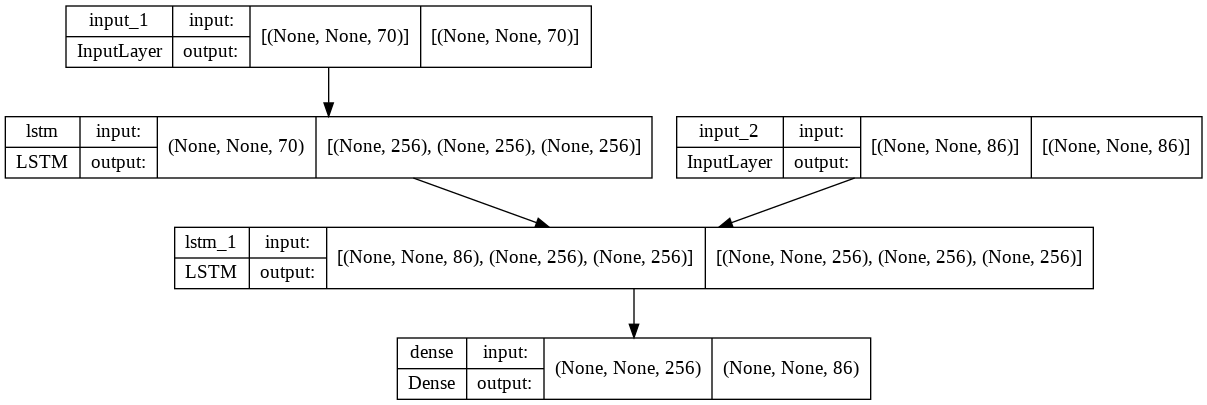

In [10]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True)

Na figura acima, vemos que nossa primeira entrada (input_1) possui dimensão 70, visto que nosso vocabulário possui 70 caracteres. Nessa entrada, serão fornecidos os caracteres da sentença de entrada. Nosso encoder (lstm) então utiliza 256 células LSTM para gerar o encoder vector (encoder_states), o qual armazena apenas os estados gerados pelo encoder a partir da entrada fornecida.

Na sequência, temos uma segunda entrada (input_2), que será utilizada no treinamento do decoder. Veja, portanto, que o treinamento possui duas entradas, a entrada 1 e a entrada 2, conforme exemplificado anteriormente. Essa entrada 2 (input_2), juntamente com o encoder vector (encoder_states), serão utilizados no decoder (lstm_1). O processamento do decoder é dado no código  por "decoder_lstm(decoder_inputs, initial_state=encoder_states)", ou seja, ele recebe como parâmetro tanto o decoder_inputs, que é baseado no input_2, quanto o estado inicial, dado pelo encoder vector (encoder_states).

Na sequência, temos uma camada densa de neurônios para processar a saída.

Agora que já entendemos como é a arquitetura interna que será utilizada no treinamento, vamos treinar o modelo:

In [11]:
#%%time
# Run training
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=BATCH_SIZE,
          epochs=NB_EPOCH, 
          validation_split=0.2)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
125/125 [==============================] - 9s 19ms/step - loss: 1.0344 - accuracy: 0.0805 - val_loss: 1.1357 - val_accuracy: 0.1061
Epoch 2/100
125/125 [==============================] - 1s 10ms/step - loss: 0.9093 - accuracy: 0.1092 - val_loss: 1.0188 - val_accuracy: 0.1314
Epoch 3/100
125/125 [==============================] - 1s 10ms/step - loss: 0.8508 - accuracy: 0.1215 - val_loss: 0.9494 - val_accuracy: 0.1467
Epoch 4/100
125/125 [==============================] - 1s 10ms/step - loss: 0.7796 - accuracy: 0.1407 - val_loss: 0.8721 - val_accuracy: 0.1688
Epoch 5/100
125/125 [==============================] - 1s 10ms/step - loss: 0.6832 - accuracy: 0.1644 - val_loss: 0.7909 - val_accuracy: 0.1901
Epoch 6/100
125/125 [==============================] - 1s 11ms/step - loss: 0.6016 - accuracy: 0.1828 - val_loss: 0.7045 - val_accuracy: 0.2067
Epoch 7/100
125/125 [==============================] - 1s 10ms/step - loss: 0.5963 - accuracy: 0.1876 - val_loss: 0.7237 - val_accuracy:

Veja que, nossa acurácia ainda está baixa, cerca de 32% de acurácia. Isso pode ser melhorado alterando-se os hiperparâmetros do modelo, tais como o BATCH_SIZE, NB_EPOCH, a quantidade de exemplos a ser considerada (num_samples) e a dimensão do espaço de encoding (latent_dim).

Vamos prosseguir com o modelo treinado acima. Vamos plotar os gráficos de acurácia e perda do treinamento:

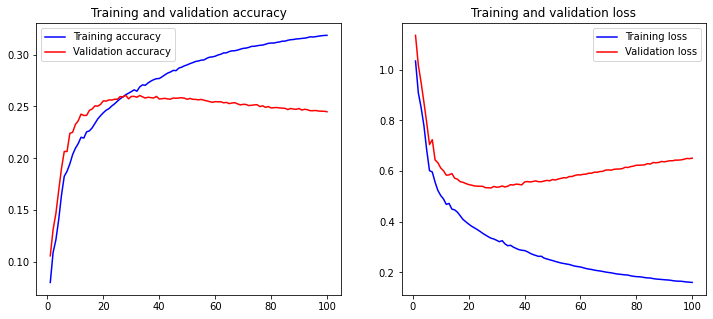

In [12]:
import matplotlib.pyplot as plt
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training accuracy')
    plt.plot(x, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
plot_history(history)   

Na figura acima, vemos o resultado do treinamento por intermédio de dois gráficos, sendo o primeiro de acurácia e o segundo da função de perda, ambos em relação às épocas de treinamento. Obtivemos um resultado de acurácia um pouco acima de 0.30 para o treino e próximo de 0.25 no teste, indicando que o nosso modelo ainda está precisando melhorar muito. Na função de perda, o treino obteve um valor abaixo de 0.20, e o teste, cerca de 0.60, ou seja, ainda bem alto. Entretanto esses resultados já eram previstos, pois utilizamos um conjunto pequeno de sentenças no nosso treinamento.

In [13]:
# Definindo modelo de previsão
encoder_model = Model(encoder_inputs, encoder_states)
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

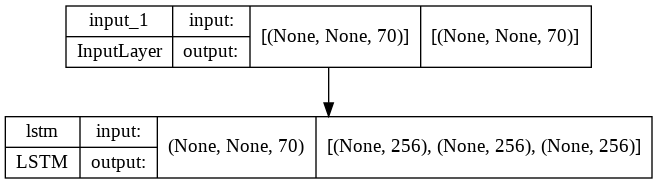

In [14]:
# Plotando o Encoder de Inferência
plot_model(encoder_model, show_shapes=True)

Na figura acima, podemos ver a estrutura do encoder, a qual utiliza a mesma entrada de 70 dimensões utilizada no treinamento, porém, internamente aproveita os pesos já treinados do modelo anterior.

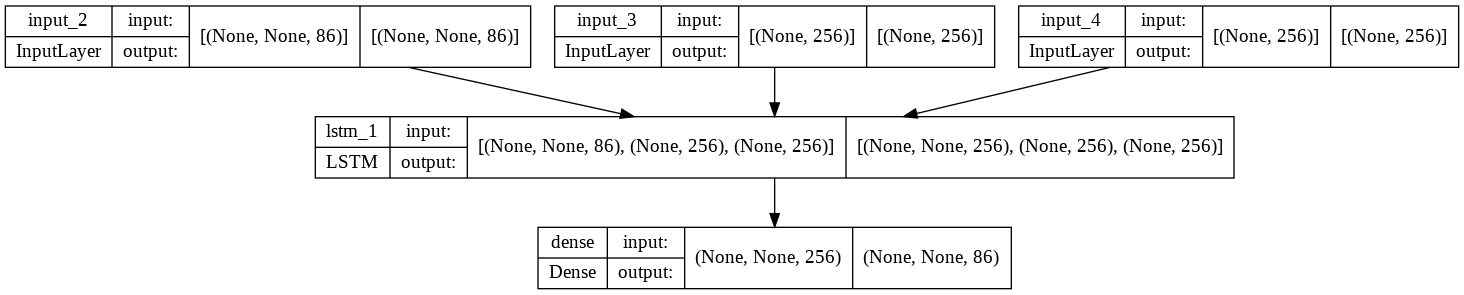

In [15]:
# Plotando o Decoder de Inferência
plot_model(decoder_model, show_shapes=True)

Vamos criar nossa função de tradução baseada no encoder e no decoder:

In [16]:
# Criação da função final para a tradução
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

def translate_eng_por(input_seq):
    # Cria primeiro o vetor oculto de estados com o Encode (encoder_model)
    states_value = encoder_model.predict(input_seq)

    # Cria uma sequência target vazia
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Popula a sequência com o caractere '\t'
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Loop para formar a saída utilizando o Decoder (decoder_model), até encontrar '\n' ou o limite de caracteres
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        # Para cada token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char
        # Condição de parada, caso encontre o tamanho máximo ou '\n'
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True
        # Atualiza a sequência de saída (target_seq)
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.
        # atualiza os estados para a próxima previsão
        states_value = [h, c]
    return decoded_sentence

Veja, no código acima, que o vetor oculto de estados (states_value) gerado pelo encoder é utilizado no decoder, conforme já explicado anteriormente. As inferências são feitas até encontrar '\n' ou o limite de caracteres, e o vetor oculto de estados é atualizado a cada nova inferência.

In [17]:
# Testando o modelo para os primeiros 1000 exemplos
for seq_index in range(1000):
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = translate_eng_por(input_seq)
    print('-')
    print('Input:', input_texts[seq_index])
    print('Output:', decoded_sentence)

-
Input: Go.
Output: Vá.

-
Input: Go.
Output: Vá.

-
Input: Hi.
Output: Oi.

-
Input: Run!
Output: Corra.

-
Input: Run!
Output: Corra.

-
Input: Run!
Output: Corra.

-
Input: Run.
Output: Corra.

-
Input: Run.
Output: Corra.

-
Input: Run.
Output: Corra.

-
Input: Who?
Output: De-sel

-
Input: Who?
Output: De-sel

-
Input: Wow!
Output: Saiado.

-
Input: Wow!
Output: Saiado.

-
Input: Wow!
Output: Saiado.

-
Input: Fire!
Output: Escura.

-
Input: Fire!
Output: Escura.

-
Input: Fire!
Output: Escura.

-
Input: Help!
Output: Ajuda.

-
Input: Help!
Output: Ajuda.

-
Input: Jump!
Output: Pule.

-
Input: Jump!
Output: Pule.

-
Input: Jump.
Output: Pulem.

-
Input: Jump.
Output: Pulem.

-
Input: Jump.
Output: Pulem.

-
Input: Stop!
Output: Pare.

-
Input: Stop!
Output: Pare.

-
Input: Stop!
Output: Pare.

-
Input: Stop!
Output: Pare.

-
Input: Stop!
Output: Pare.

-
Input: Wait!
Output: Aguarde.

-
Input: Wait!
Output: Aguarde.

-
Input: Wait.
Output: Esperem.

-
Input: Wait.
Output: Espere

FIM